## Project: Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, I'm working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, import the libraries.

In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#Setting the same seed assures you get the same answers
random.seed(42)

`1.` Reading in the `ab_data.csv` data. Storing it in `df`.

In [50]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Finding out the number of rows in the dataset.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset.

In [52]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [53]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [54]:
treat = df[df['group'] == 'treatment']
nomatch_t = treat[treat['landing_page'] != 'new_page']
nomatch_t_c = nomatch_t.count()
nomatch_t_c['user_id']

1965

In [55]:
control = df[df['group'] == 'control']
nomatch_c = control[control['landing_page'] != 'old_page']
nomatch_c_c = nomatch_c.count()
nomatch_c_c['user_id']

1928

In [56]:
nomatch = nomatch_c + nomatch_t
nomatch

,user_id,timestamp,group,landing_page,converted
22,NaN,NaN,NaN,NaN,NaN
240,NaN,NaN,NaN,NaN,NaN
308,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN
357,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
294014,NaN,NaN,NaN,NaN,NaN
294200,NaN,NaN,NaN,NaN,NaN
294252,NaN,NaN,NaN,NaN,NaN
294253,NaN,NaN,NaN,NaN,NaN


Do any of the rows have missing values?

No. -> See df.info() above.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Creating a new dataset that meets the specifications.  Storing the new dataframe in **df2**.

In [57]:
df2 = df.drop(nomatch.index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [58]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3.

How many unique **user_id**s are in **df2**?

In [59]:
df2['user_id'].nunique()

290584

Finding out a duplicate user.

In [60]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [61]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**, but keeping the dataframe as **df2**.

In [62]:
df2 = df2.drop(index=1899)

In [63]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` What is the probability of an individual converting regardless of the page they receive?

In [64]:
converted = df2['converted'].mean()
converted

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [65]:
converted_old = df2[df2['group'] == 'control']['converted'].mean()
converted_old

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [66]:
converted_new = df2[df2['group'] == 'treatment']['converted'].mean()
converted_new

0.11880806551510564

In [67]:
obs_diff = converted_new - converted_old
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [68]:
np_c = df2[df2['landing_page'] == 'new_page'].nunique()

In [69]:
np_c / df2.nunique()

user_id         0.500062
timestamp       0.500062
group           0.500000
landing_page    0.500000
converted       1.000000
dtype: float64

Considering the results from parts (a) through (d) above, is there sufficient evidence to conclude that the new treatment page leads to more conversions?

***There isn't sufficient evidence to conclude that the new treatment page leads to more conversions. My opinion is based on the conversion rates between the groups.***

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, there could be a hypothesis test continuously as each observation was observed.  

However, then the hard question is whether to stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we will make the decision just based on all the data provided.  Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, the null and alternative hypotheses should be as follows.

***
H0 = **$p_{new}$** - **$p_{old}$** = 0
<br>
H1 = **$p_{new}$** - **$p_{old}$** > 0
***

**$p_{old}$** and **$p_{new}$** are the converted rates for the old and new pages.

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

What is the **conversion rate** for $p_{new}$ under the null? 

In [70]:
p_new = df['converted'].mean()
p_new

0.11965919355605512

What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [71]:
p_old = df['converted'].mean()
p_old

0.11965919355605512

What is $n_{new}$, the number of individuals in the treatment group?

In [73]:
n_new = df2.query('group == "treatment"')['group'].count()
n_new

145310

What is $n_{old}$, the number of individuals in the control group?

In [75]:
n_old = df2.query('group == "control"')['group'].count()   
n_old

145274

In [76]:
n_total = n_new + n_old
n_total

290584

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [77]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.11906957539054436

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [78]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.12001459311370238

Finding $p_{new}$ - $p_{old}$ for the simulated values.

In [79]:
obs_diff_null = p_new - p_old
obs_diff_null

0.0

Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used above. Storing all 10,000 values in a NumPy array called **p_diffs**.

In [80]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000) / n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plotting a histogram of the **p_diffs**.

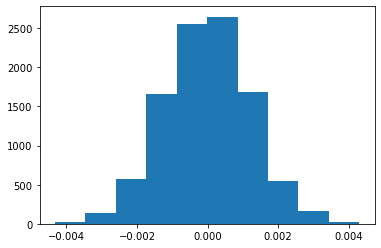

In [81]:
plt.hist(p_diffs);

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

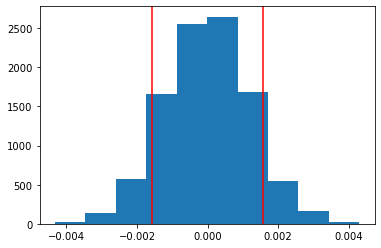

In [82]:
lo_prob = (p_diffs < obs_diff).mean()
hi_prob = (p_diffs.mean() + (p_diffs.mean() - obs_diff) < p_diffs).mean()

plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');
plt.axvline(p_diffs.mean() + (p_diffs.mean() - obs_diff), color='red');

In [83]:
p_value = lo_prob + hi_prob
p_value

0.1832

***The proportion of the p_diffs greater than the actual difference observed in ab_data.csv is called the p-value. P-value is all the null values that are more extreme than the observed difference statistic in favor of the alternative hypothesis.
<br><br>
With a p-value of more than our alpha of 0.05 it seems likely that the statistic is from this null so we fail to reject the null.***

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculating below the number of conversions for each page, as well as the number of individuals who received each page. Letting `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()

Using `stats.proportions_ztest` to compute your test statistic and p-value. Documentation: [statsmodels.stats.proportion.proportions_ztest](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/)

In [85]:
from statsmodels.stats.proportion import proportions_ztest

z_score, p_value = proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


***Z-score gives an idea of how far from the mean a data point is. It’s a measure of how many standard deviations below or above the population mean a raw score is. <br>
Source: https://www.statisticshowto.com/probability-and-statistics/z-score/ <br><br>
In our case, the z-score is 1.2508 standard deviations above the mean, which is the difference between the conversion rates and the null hypothesis. This is less than the critical 1.645 which we would need to reject the null hypothesis when our alpha is 0.05. <br> Source: https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_hypothesistest-means-proportions/bs704_hypothesistest-means-proportions3.html <br><br>
Additionally, the p-value here is 0.9051, which is not below our alpha of 0.05. This p-value is equal or near one calculated by bootstrapping (~0.90).***

<a id='regression'></a>
### Part III - A regression approach

`1.` The result  achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, we should be performing a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model specified above to see if there is a significant difference in conversion based on which page a customer receives. Adding an **intercept** column, as well as an **ab_page** dummy variable column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [86]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [87]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop(columns='control')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Using **statsmodels** to instantiate the regression model on the two new columns and fitting the model to predict whether or not an individual converts. 

In [88]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The summary of the model:

In [89]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-12-28 13:28 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**The p-value of ab_page with the logistic regression model is 0.1899 which is just a little bit less than in the previous tests. The logistic regression model is trying to predict whether a user will convert depending on their landing page. <br><br> The null hypothesis is that when the landing page is the new page, there will be no conversion and the alternative hypothesis is that when the landing page is the new page, there will be conversion.  <br><br> In Part II the null hypothesis was that the conversion rates would be equal and the alternative hypothesis was that the new page would have a higher conversion rate.**

**It would be also possible to consider how the date and time affects the conversion rates. It's good to consider adding other factors into the model in case it makes it more reliable. It's always a possibility that there would be multicollinearity with the variables and that would have to be addressed first by finding and removing the variables causing this.**

Now along with testing if the conversion rate changes for different pages, adding an effect based on which country a user lives in. Reading in the **countries.csv** dataset and merging together the datasets on the appropriate rows. 

Does it appear that country had an impact on conversion?

In [90]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [91]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [92]:
df2 = df2.join(countries.set_index('user_id'), on='user_id')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   intercept     290584 non-null  int64 
 6   ab_page       290584 non-null  uint8 
 7   country       290584 non-null  object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


In [93]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [94]:
df2['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Looking at an interaction between page and country to see if there significant effects on conversion.  Creating the necessary additional columns and fitting the new model.  

In [95]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [96]:
log_mod2 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [97]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-12-28 13:28 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**The p-value of ab_page with the second logistic regression model is 0.1912 which is just a little bit higher than in the previous logistic regression model. This seems to indicate that adding the countries to the model is not making the alternative hypothesis stronger. Also it seems that it isn't statistically significant whether the user is in UK or US. There might be some affect if the user is in CA.**

<a id='conclusions'></a>
## Finishing Up

You have reached the end of the A/B Test Results project!